# 4章 4.2 EGM を用いた TI の準コード

In [586]:
# パッケージのインポート

import numpy as np
import numpy.typing as npt
from numpy.polynomial.chebyshev import Chebyshev
import matplotlib.pyplot as plt
# import japanize_matplotlib
import math
from scipy.stats import norm

### 1. パラメータをカリブレーション

In [587]:
# パラメータをカリブレーション
beta = 0.96
gamma = 1.0
alpha = 0.4 # 1を割った時に正数となる値にすると f_tildeで複素数を回避できる
delta = 1.0

### 2. 収束の基準を定義

In [588]:
# 収束の基準を定義
epsilon = 1e-5

### 3. 制御変数のグリッドを生成

- $\{ k^\prime \}_{i = 1}^N, \;\; N = 21$
- $k_1^\prime = 0, k_{21}^\prime = 0.5$

In [589]:
# 制御変数のグリッドを生成
nk = 20
Kprime_grid = np.linspace(0.25, 5.0, nk)
print(Kprime_grid)

[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


### 4. 確率変数$z$のグリッド$\{ z_j \}_{j = 1}^N$を生成（Tauchenの方法）

In [ ]:
# パラメータの値は教科書に則ったもの
nz = 12 # 0を避けるために12に設定
rho = 0.95
sigma = 0.01
m = 2.575
Z_max = m * sigma / math.sqrt(1 - rho**2)
Z_grid = np.linspace(-Z_max, Z_max, nz)
print(Z_grid)

### 4. 確率変数のグリッド$\{z_j\}^2_{j = 1}$を生成（$z_{high},z_{low}$）

In [590]:
nz = 4
Z_grid = np.zeros(nz)
Z_grid = np.array([-0.5, -0.25, 0.25, 0.5])

### 5. $N_z \times N_z$の遷移確率行列を定義（Tauchenの方法）

In [ ]:
# Tauchenの方法
d = 2 * Z_max / (nz - 1)
P = np.zeros((nz, nz))
for i in range(nz):
    for j in range(nz):
        if j == 0:
            P[i, j] = norm.cdf(Z_grid[j] + d / 2 - rho * Z_grid[i], loc = 0, scale = sigma)
        elif j == nz:
            P[i, j] = 1 - norm.cdf(Z_grid[j] - d / 2 - rho * Z_grid[i], loc = 0, scale = sigma)
        else:
            P[i, j] = norm.cdf(Z_grid[j] + d /2 - rho * Z_grid[i], sigma) - norm.cdf(Z_grid[j] - d / 2 - rho * Z_grid[i], loc = 0, scale = sigma)
# np.printoptions(precision = 5)
print(P)

### 5. $N_z \times N_z$の遷移確率行列を手置き定義 

In [591]:
# 0.8 0.6 0.4 0.2 からなる遷移確率行列 4x4
P = np.array([[0.6, 0.3, 0.1, 0.0], [0.1, 0.6, 0.2, 0.1], [0.0, 0.1, 0.6, 0.3], [0.2, 0.1, 0.3, 0.6]])

### 6. 初期値として政策関数を当て推量 $c_{i, t} = h^{(0)}(k_i^\prime, z_t)$

In [592]:
# 6. 初期値として政策関数を当て推量 $c_{i, t} = h^{(0)}(k_i^\prime, z_t)$を設定
# kprime と z の値に従って, 増加するような c を生成
h_old_grid = np.dot(Kprime_grid.reshape(nk, 1),np.exp(Z_grid).reshape(1, nz)) * 0.8
np.set_printoptions(precision=3)
print(h_old_grid)

[[0.121 0.156 0.257 0.33 ]
 [0.243 0.312 0.514 0.659]
 [0.364 0.467 0.77  0.989]
 [0.485 0.623 1.027 1.319]
 [0.607 0.779 1.284 1.649]
 [0.728 0.935 1.541 1.978]
 [0.849 1.09  1.798 2.308]
 [0.97  1.246 2.054 2.638]
 [1.092 1.402 2.311 2.968]
 [1.213 1.558 2.568 3.297]
 [1.334 1.713 2.825 3.627]
 [1.456 1.869 3.082 3.957]
 [1.577 2.025 3.338 4.287]
 [1.698 2.181 3.595 4.616]
 [1.82  2.336 3.852 4.946]
 [1.941 2.492 4.109 5.276]
 [2.062 2.648 4.366 5.606]
 [2.184 2.804 4.622 5.935]
 [2.305 2.959 4.879 6.265]
 [2.426 3.115 5.136 6.595]]


### 7. 次のステップを収束するまで繰り返す(繰り返し記号：n)
   1. 古い政策関数 $h^{(n-1)}(k_i^\prime)$ を所与として，$\{k^\prime_i\}_{i=1}^{N_k} \times \{z_s\}_{s=1}^{N_z}$ の各グリッドについて
   	
      - $c_{i, s} = u^{\prime -1} ( \beta \sum_{t=1}^{N_z} \{ P_{s,t} u^\prime(h^{(n-1)}(k^\prime_i, z_t)) \times \tilde{f}^\prime (k^\prime_i, z_t)\} )$
      - $c_{i,s} + k^\prime_i = \tilde{f}(k_i, z_s) \Rightarrow k_i = \tilde{f}^{-1} (c_{i,s} + k^\prime_i)$

In [593]:
# ステップ7の準備（ndarrayが前提）
def u_prime(c: float) -> float:
    return c**(-gamma)
def u_prime_inv(mu: float) -> float:
    return mu**(-1/gamma)
def f_tilde(k: float, z: float) -> float:
    return np.exp(z) * k**alpha
def f_tilde_prime(k: float, z: float) -> float:
    return alpha * np.exp(z) * k**(alpha - 1)
def f_tilde_inv(y: float, z: float) -> float:
    result = (y / math.exp(z))**(1 / alpha) 
    return result

def interpolate_cheb(k_matrix,z_list,c_matrix):
    """チェビシェフ補間を行う関数を返す関数

    Args:
        k: 計算された k の行列 k[i, j]
        z (npt.NDArray): 説明変数 z の配列（離散化された状態の長さ分）
        c (npt.NDArray): 目的変数 c の配列
    """
    def interp_func(k,z):
        # z_list から zと一致する要素の番号を得る
        z_idx = np.where(z_list == z)[0][0]
        # k_matrixから k_matrix[i, z_idx]の配列を得る
        k_list = k_matrix[:, z_idx]
        c_list = c_matrix[:, z_idx]
        cheb_fit = Chebyshev.fit(k_list, c_list, deg=8)
        
        return cheb_fit(k)
    
    return interp_func

In [594]:
diff = epsilon + 1
loop = 0
while diff > epsilon:
    loop += 1
    Gamma = np.zeros((nk, nz)) # オイラー方程式の右辺
    C0 = np.zeros((nk, nz))
    K = np.zeros((nk, nz))
    
    for i in range(nk):
        for j in range(nz):
            for k in range(nz):
                Gamma[i, j] += beta * P[j, k] * u_prime(h_old_grid[i, k]) * (f_tilde_prime(Kprime_grid[i], Z_grid[k]))
            C0[i, j] = u_prime_inv(Gamma[i, j])
            K[i, j] = f_tilde_inv(C0[i, j] + Kprime_grid[i], Z_grid[j])


    h_new_func = interpolate_cheb(K, Z_grid, C0)
    np_h_new_func = np.frompyfunc(h_new_func, 2, 1)

    # # 収束の確認
    K_matrix = np.zeros((nk, nz))
    for i in range(nk):
        K_matrix[i, :] = Kprime_grid[i]
    print(K_matrix)
    Z_matrix = np.array(list(Z_grid) * nk).reshape(nk, nz)
    print(Z_matrix)
    h_new_grid = np_h_new_func(K_matrix, Z_matrix)
    diff = np.max(np.abs(h_new_grid - h_old_grid))
    
    h_old_grid = h_new_grid

print(h_old_grid)

[[0.25 0.25 0.25 0.25]
 [0.5  0.5  0.5  0.5 ]
 [0.75 0.75 0.75 0.75]
 [1.   1.   1.   1.  ]
 [1.25 1.25 1.25 1.25]
 [1.5  1.5  1.5  1.5 ]
 [1.75 1.75 1.75 1.75]
 [2.   2.   2.   2.  ]
 [2.25 2.25 2.25 2.25]
 [2.5  2.5  2.5  2.5 ]
 [2.75 2.75 2.75 2.75]
 [3.   3.   3.   3.  ]
 [3.25 3.25 3.25 3.25]
 [3.5  3.5  3.5  3.5 ]
 [3.75 3.75 3.75 3.75]
 [4.   4.   4.   4.  ]
 [4.25 4.25 4.25 4.25]
 [4.5  4.5  4.5  4.5 ]
 [4.75 4.75 4.75 4.75]
 [5.   5.   5.   5.  ]]
[[-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]
 [-0.5  -0.25  0.25  0.5 ]

### 政策関数を 3次元プロット

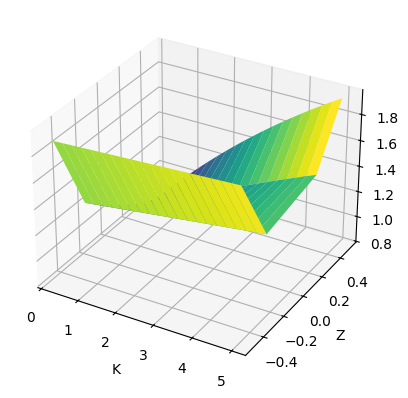

21
8.658593266375192e-06


In [595]:
# np_h_new_func を使って三次元プロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_matrix, Z_matrix, np_h_new_func(K_matrix, Z_matrix), cmap='viridis')
ax.set_xlabel('K')
ax.set_ylabel('Z')
ax.set_zlabel('c')
plt.show()
print(loop)
print(diff)

### z の値を固定した政策関数の二次元プロット

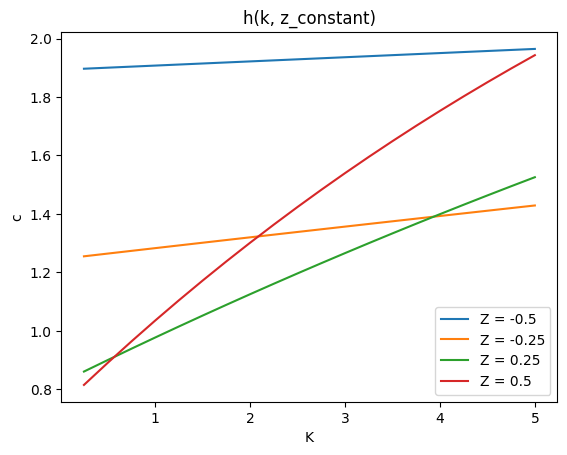

In [596]:
# Z_grid の要素ごとに 縦軸 np_h_new_func(K_grid, Z)を同じグラフにプロット
for j in range(nz):
    Z_repeat = np.repeat(Z_grid[j], nk)
    C = np.zeros((nz, nk))
    C[j, :] = np_h_new_func(Kprime_grid, Z_repeat)
    plt.plot(Kprime_grid, C[j,:], label=f'Z = {Z_grid[j]}')
plt.xlabel('K')
plt.ylabel('c')
plt.title('h(k, z_constant)')
plt.legend()
plt.show()

### $Z_t$ の流列を生成し、$K, C$の流列をシミュレーション

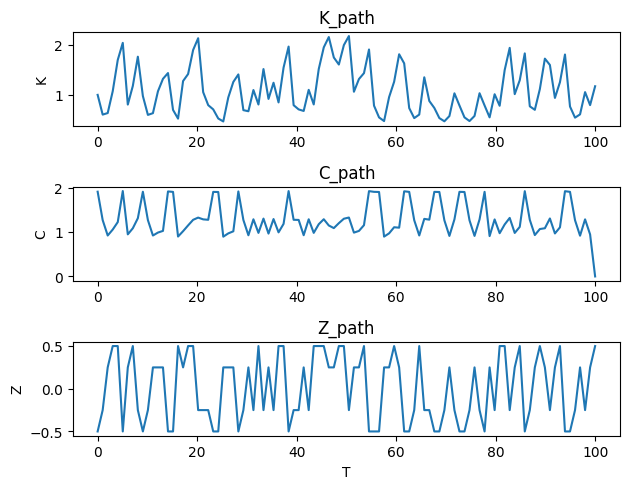

In [597]:
# 確率的シミュレーション
T = 100
# 0-100まで
T_series = np.linspace(0, T, T)
K_path = np.zeros(T)
Z_path = np.zeros(T)
C_path = np.zeros(T)
K_path[0] = 1.0

# Z_gridから Z_pathの値をランダムに生成
for t in range(T):
  Z_path[t] = Z_grid[np.random.choice(nz)]

for t in range(1, T):
  C_path[t-1] = h_new_func(K_path[t-1], Z_path[t-1])
  K_path[t] = f_tilde(K_path[t-1], Z_path[t-1]) - C_path[t]

# K_path, C_path, Z_path を T_series を横軸に3つ縦に並べてプロット
# グラフの描画領域
fig = plt.figure()
# サブプロットの追加
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
# プロット
ax1.plot(T_series, K_path, label='K')
ax2.plot(T_series, C_path, label='C')
ax3.plot(T_series, Z_path, label='Z')
# ラベル
ax1.set_ylabel('K')
ax2.set_ylabel('C')
ax3.set_ylabel('Z')
# タイトル
ax1.set_title('K_path')
ax2.set_title('C_path')
ax3.set_title('Z_path')
fig.tight_layout()
plt.xlabel('T')
plt.show()

In [585]:
%reset -f